In [1]:
from deepface import DeepFace
from matplotlib import pyplot as plt
import cv2
import numpy as np
import mediapipe as mp
import supervision as sv

## Getting the reference image

In [2]:
face_objs = DeepFace.extract_faces(
    img_path="reference_image.jpg",
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

In [19]:
OUTPUT_SIZE = (200, 200)

def fit_to_output_size(frame: np.ndarray) -> np.ndarray:
    """
    Resize a frame to the output size.
    """
    return cv2.resize(frame, OUTPUT_SIZE)

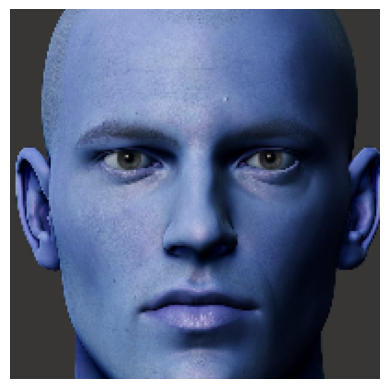

In [20]:
face = face_objs[0]["face"]
frame = fit_to_output_size(face)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [21]:
VERTEX_COLOR = sv.Color.WHITE
VERTEX_RADIUS = 1

model = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=False,       # Set to True if working with still images
    refine_landmarks=True,         # Enables more precise landmark detection (includes irises)
    max_num_faces=1,               # Number of faces to detect
    min_detection_confidence=0.5,  # Minimum detection confidence
    min_tracking_confidence=0.5,   # Minimum tracking confidence
)
annotator = sv.VertexAnnotator(color=VERTEX_COLOR, radius=VERTEX_RADIUS)

In [22]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)

In [23]:
def get_xyz_from_processed_frame(processed_frame):
    results = [
                face_landmark.landmark
                for face_landmark in processed_frame.multi_face_landmarks
            ]

    xyz = []
    for pose in results:
        prediction_xyz = []
        prediction_confidence = []
        for landmark in pose:
            keypoint_xyz = [
                landmark.x,
                landmark.y,
                landmark.z,  # z-coordinate (relative to camera in meters) scaled to image width
            ]
            prediction_xyz.append(keypoint_xyz)
            prediction_confidence.append(landmark.visibility)

        xyz.append(prediction_xyz)

    return xyz

In [8]:
def get_scaled_xy_from_xyz(xyz):
    xy = [[x, y] for (x, y, _) in xyz]

    return np.array(xy)

In [24]:
get_xyz_from_processed_frame(processed_frame)

[[[0.5068244338035583, 0.7610746026039124, -0.08991289138793945],
  [0.5232137441635132, 0.6373401880264282, -0.18295139074325562],
  [0.5194353461265564, 0.6700619459152222, -0.09020373225212097],
  [0.4906483590602875, 0.5168508291244507, -0.1458188146352768],
  [0.5236395597457886, 0.6017325520515442, -0.19701306521892548],
  [0.5226568579673767, 0.5529617071151733, -0.18598952889442444],
  [0.5186721682548523, 0.4327212870121002, -0.10275092720985413],
  [0.2640402913093567, 0.42122578620910645, 0.024311158806085587],
  [0.5161313414573669, 0.3536733388900757, -0.08856157958507538],
  [0.5158737301826477, 0.3081681430339813, -0.10028670728206635],
  [0.5150628685951233, 0.11497610807418823, -0.07204930484294891],
  [0.5073767304420471, 0.773783266544342, -0.08405479788780212],
  [0.5078434348106384, 0.7876430153846741, -0.07063067704439163],
  [0.5084487199783325, 0.797809362411499, -0.04859941452741623],
  [0.5082011222839355, 0.7993831038475037, -0.050687722861766815],
  [0.50936

In [25]:
np.save('key_points_xyz.npy', get_xyz_from_processed_frame(processed_frame))

In [26]:
loaded_key_points = np.load('key_points_xyz.npy')
print(loaded_key_points)

[[[ 0.50682443  0.7610746  -0.08991289]
  [ 0.52321374  0.63734019 -0.18295139]
  [ 0.51943535  0.67006195 -0.09020373]
  ...
  [ 0.69681525  0.37058878  0.02683313]
  [ 0.6612196   0.40004259  0.02683313]
  [ 0.69552499  0.42800242  0.02683313]]]


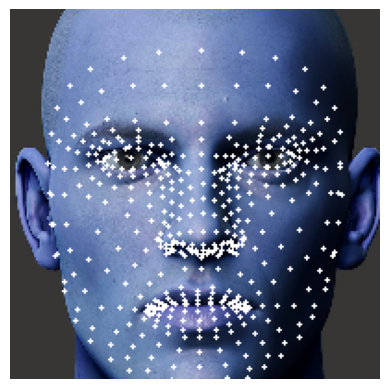

In [27]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Get the face for frontalization

In [42]:
face_objs = DeepFace.extract_faces(
    img_path="test_image.png",
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

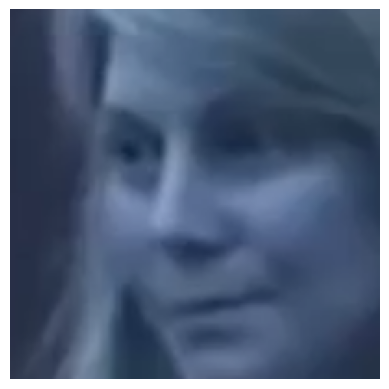

In [43]:
face = face_objs[0]["face"]
frame = fit_to_output_size(face)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [44]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)
key_points.xy = key_points.xy[:1]

In [45]:
image_to_frontalize_xyz = get_xyz_from_processed_frame(processed_frame)
image_to_frontalize_xyz

[[[0.48895901441574097, 0.7820559740066528, -0.07619018852710724],
  [0.43412744998931885, 0.6267637014389038, -0.15437015891075134],
  [0.4730759263038635, 0.6632487177848816, -0.07859141379594803],
  [0.41534245014190674, 0.5034624338150024, -0.10688946396112442],
  [0.4258154630661011, 0.5889776945114136, -0.1659393161535263],
  [0.42941349744796753, 0.5387985706329346, -0.15634924173355103],
  [0.44974303245544434, 0.4113237261772156, -0.0839511826634407],
  [0.2934950292110443, 0.3991183638572693, 0.1342778205871582],
  [0.4466806948184967, 0.30367597937583923, -0.06812193244695663],
  [0.4374121129512787, 0.2521742284297943, -0.07623528689146042],
  [0.42246490716934204, 0.07883942127227783, -0.05792057514190674],
  [0.4944833517074585, 0.7935523986816406, -0.07090825587511063],
  [0.5033877491950989, 0.802709698677063, -0.060185253620147705],
  [0.5135101675987244, 0.8082727789878845, -0.04505522549152374],
  [0.5183859467506409, 0.8177914619445801, -0.04361971095204353],
  [0.5

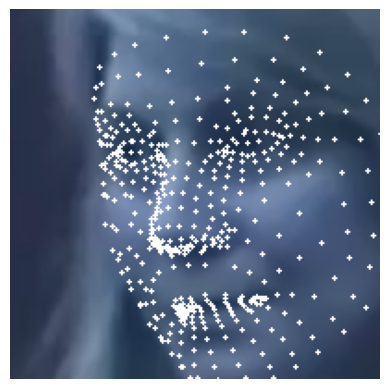

In [46]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Frontalization

In [56]:
face_to_frontalize_keypoints = np.array(image_to_frontalize_xyz)
reference_keypoints = np.load('key_points_xyz.npy')

print("Shape of face_to_frontalize_keypoints:", face_to_frontalize_keypoints.shape)
print("Shape of reference_keypoints:", reference_keypoints.shape)

Shape of face_to_frontalize_keypoints: (1, 478, 3)
Shape of reference_keypoints: (1, 478, 3)


### AffinePartial3D

In [52]:
# Estimate the affine transformation
retval, matrix, inliers = cv2.estimateAffine3D(face_to_frontalize_keypoints[0], reference_keypoints[0])
frontalized_keypoints = cv2.transform(face_to_frontalize_keypoints, matrix)[0]

### Procrustes Analysis

In [57]:
def procrustes_analysis(X, Y):
    """
    Perform Procrustes analysis to align X to Y.
    X and Y are expected to have shape (N, 3) where N is the number of keypoints.
    """
    # Subtract the centroid (mean) of the points
    X_mean = np.mean(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    
    X_centered = X - X_mean
    Y_centered = Y - Y_mean
    
    # Normalize the points (scaling to unit variance)
    X_norm = np.linalg.norm(X_centered)
    Y_norm = np.linalg.norm(Y_centered)
    
    X_centered /= X_norm
    Y_centered /= Y_norm
    
    # Compute the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(np.dot(X_centered.T, Y_centered))
    R = np.dot(U, Vt)
    
    # Apply the rotation matrix to X
    X_aligned = np.dot(X_centered, R)
    
    # Rescale and shift X_aligned back to original scale and position
    X_aligned = X_aligned * Y_norm + Y_mean
    
    return X_aligned

frontalized_keypoints = procrustes_analysis(face_to_frontalize_keypoints[0], reference_keypoints[0])

## Frontalized visualization

In [58]:
frontalized_keypoints = get_scaled_xy_from_xyz(frontalized_keypoints)
face_to_frontalize_keypoints = get_scaled_xy_from_xyz(face_to_frontalize_keypoints[0])
reference_keypoints = get_scaled_xy_from_xyz(reference_keypoints[0])

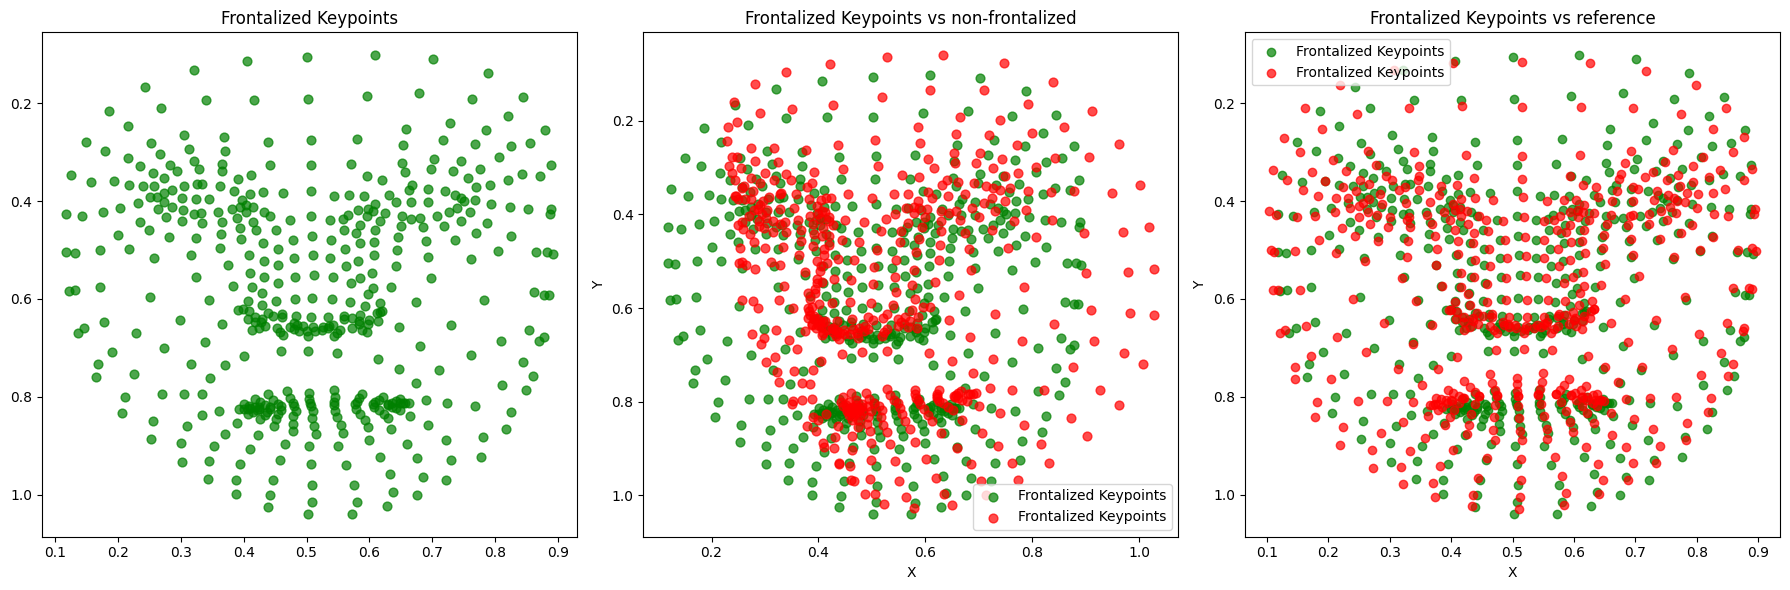

In [59]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size for better spacing

# Just frontalized
plt.subplot(1, 3, 1)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs non-frontalized
plt.subplot(1, 3, 2)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.scatter(face_to_frontalize_keypoints[:, 0], face_to_frontalize_keypoints[:, 1], 
            color='red', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints vs non-frontalized')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs Reference
plt.subplot(1, 3, 3)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7)

plt.scatter(reference_keypoints[:, 0], reference_keypoints[:, 1], 
            color='red', label='Frontalized Keypoints', alpha=0.7)

plt.title(f'Frontalized Keypoints vs reference')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()